In [171]:
from joblib import Parallel, delayed, cpu_count

import psycopg2

import pandas as pd
import pandas.io.sql as sqlio

import funcy as fp

import re

from multiprocessing import Pool
import numpy as np

import gensim
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, LdaMulticore, TfidfModel
from gensim.models.wrappers import LdaMallet
from gensim.similarities import Similarity, MatrixSimilarity, SparseMatrixSimilarity

# import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.test.utils import get_tmpfile
from gensim.matutils import hellinger, corpus2csc, corpus2dense
from gensim.utils import to_utf8, tokenize
from gensim.models.phrases import Phrases, Phraser
from gensim.parsing.preprocessing import strip_tags, preprocess_string, remove_stopwords, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_numeric, strip_non_alphanum

import pickle

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, hamming_loss, accuracy_score, confusion_matrix, roc_curve, classification_report

from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from skmultilearn.adapt import MLkNN, BRkNNaClassifier, BRkNNbClassifier
from skmultilearn.neurofuzzy import MLARAM
from sklearn.multiclass import OneVsRestClassifier

import scipy
import itertools

In [174]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [2]:
def save_pickle(file_name, object_to_pickle):
    with open(file_name, 'wb') as f:
        pickle.dump(object_to_pickle, f)
        
def load_pickle(file_name):
    with open(file_name, 'rb') as f:
        unpickled_object = pickle.load(f)
    return unpickled_object

In [3]:
lda_100_corpus = gensim.corpora.MmCorpus('lda_100_corpus.mm')
print(lda_100_corpus)
lsi_300_corpus = gensim.corpora.MmCorpus('lsi_300_corpus.mm')
print(lsi_300_corpus)
index_to_id_list = load_pickle('story_ids_list')
print(len(index_to_id_list))

MmCorpus(25000 documents, 100 features, 2500000 non-zero entries)
MmCorpus(25000 documents, 300 features, 7500000 non-zero entries)
25000


In [4]:
def get_series_index(story_id):
    story_ids_map_dict = {story_id: series_index for series_index, story_id in enumerate(index_to_id_list)}
    return story_ids_map_dict[story_id]

In [5]:
%%time

lda_100_csc = corpus2csc(lda_100_corpus)

CPU times: user 2.68 s, sys: 41.3 ms, total: 2.72 s
Wall time: 2.73 s


In [6]:
%%time

lsi_300_csc = corpus2csc(lsi_300_corpus)

CPU times: user 8.43 s, sys: 207 ms, total: 8.64 s
Wall time: 8.83 s


In [7]:
%%time

conn = psycopg2.connect("host=localhost dbname=postgres user=postgres")

titles_df = sqlio.read_sql_query("SELECT id, title FROM bq_all WHERE all_text IS NOT NULL AND all_text != '' AND article_content IS NOT NULL AND article_content != '' ORDER BY score DESC, story_time DESC LIMIT 25000", conn, index_col='id')

CPU times: user 23.7 ms, sys: 10.4 ms, total: 34.1 ms
Wall time: 697 ms


In [8]:
tag_regex_dict = {
    "Python": r'python|pandas|numpy|scipy|matplotlib|pydata|django',
    "Mobile": r'mobile|android|iphone|phone|\bios\b|react native',
    "Design": r'design',
    "Security": r'security|worm|ransomware|attack|virus|patch|infosec',
    "Blockchain": r'blockchain|bitcoin|ethereum|solidity|dapps|smart contract',
    "AI/Machine Learning": r'\bai\b|artificial intelligence|machine learning|deep learning|tensorflow|machine intelligence|reinforcement learning|unsupervised learning|supervised learning|neural network|image classification',
    "Google": r'google|goog',
    "Microsoft": r'microsoft|msft|windows|visual studio|azure',
    "Apple": r'apple|aapl|mac\b|os ?x',
    "Facebook": r'facebook|\bfb\b',
    "Amazon": r'amazon|amzn|\baws\b',
    "Startups": r'startup|\bvc\b',
    "Politics": r'trump|comey|russian|fbi|snowden|neutrality|white house|government|brexit|nsa',
    "Databases": r'sql|cockroachdb|mongodb|mariadb|orientdb|couchdb|database|\bdb\b|dbms|oltp|\bolap\b|neo4j|\bredis\b',
    "Linux": r'linux|debian|ubuntu|centos',
    "Data Science": r'data scien|big data|data vi|data ?set|data analy|machine learning|pandas|ggplot2|numpy|scipy|matplotlib|pydata|statistical learning|statistical program|\bsas\b|spss|bayesian|frequentist',
    "Science": r'bio|drug|researcher|genomic|physics|scienti|spacex|\\bmoon\\b|nasa|\\bastro|\\bmars\\b',
    "Math": r'math|geome|cryptograph|algebra|calculus|graph theory|game theory|differential equations|trigonometry',
    "Javascript": r'javascript|jquery|d3|angular|redux|\.js|ecmascript|\bvue',
    "Web Dev": r'web app|javascript|\.js|front.?end|ruby on rails|django|css|web.*dev',
    "DevOps": r'sys.*admin|dev.*ops|kubernetes|docker|containerization|container|virtualization|serverless|continuous integration|continuous deployment|continuous delivery|site reliability|ec2|\bebs\b',
    "Hardware/IoT": r'raspberry pi|electronics|analog computer|arduino|micro.?controller|micro.?processor|\biot\b|internet of things',
    "AR/VR": r'augmented reality|\bar\b|virtual reality|\bvr\b|htc vive|oculus|google cardboard|hololens',
    "Games": r'steam gam|video gam|mobile gam|pc gam|indie gam|nintendo|\bsnes\b|gaming|game.*dev|unreal engine|xbox|rpg|multiplayer'
}

tags_list = list(tag_regex_dict.keys())

tags_dict = {tag: [] for tag in tags_list}

def tag_titles(title):
    lowercase = title.lower()
    for tag in tags_list:
        regex_pattern = tag_regex_dict[tag]
        if re.search(regex_pattern, lowercase): 
            tags_dict[tag].append(1)
        else:
            tags_dict[tag].append(0)
    return

In [205]:
tags_list

['Python',
 'Mobile',
 'Design',
 'Security',
 'Blockchain',
 'AI/Machine Learning',
 'Google',
 'Microsoft',
 'Apple',
 'Facebook',
 'Amazon',
 'Startups',
 'Politics',
 'Databases',
 'Linux',
 'Data Science',
 'Science',
 'Math',
 'Javascript',
 'Web Dev',
 'DevOps',
 'Hardware/IoT',
 'AR/VR',
 'Games']

In [9]:
%%time

titles_df["title"].map(tag_titles)

for tag, encoding in tags_dict.items():
    titles_df[tag] = encoding
    
no_tags_ids = titles_df[(titles_df[list(tags_list)] == 0).all(axis=1)].index.values
has_tags_ids = titles_df[(titles_df[list(tags_list)] != 0).any(axis=1)].index.values

print("{} stories have no tags".format(len(no_tags_ids)))
print("{} stories have tags".format(len(has_tags_ids)))

17412 stories have no tags
7588 stories have tags
CPU times: user 2.11 s, sys: 43.3 ms, total: 2.16 s
Wall time: 2.36 s


In [10]:
tagged_df = titles_df.loc[has_tags_ids, :]

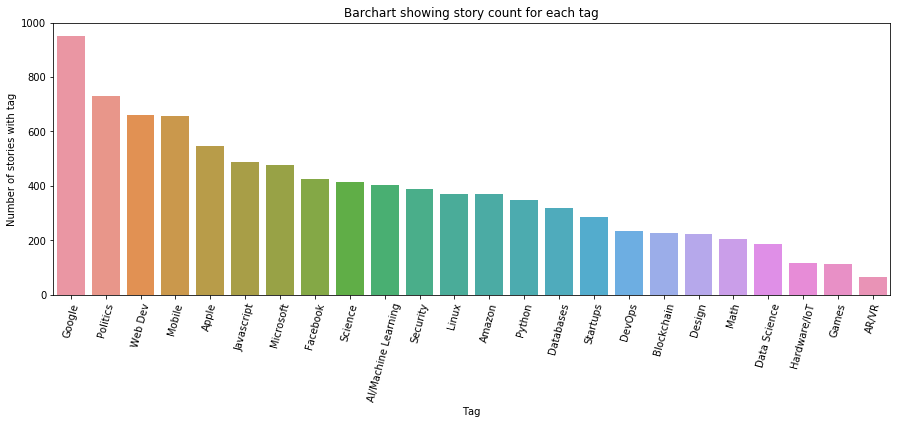

CPU times: user 397 ms, sys: 37.9 ms, total: 435 ms
Wall time: 469 ms


In [11]:
%%time

tag_count_df = tagged_df.sum(axis='index', numeric_only=True)
tag_count_df = tag_count_df.to_frame(name="count")
tag_count_df = tag_count_df.sort_values(by="count", ascending=False)
tag_count_df = tag_count_df.reset_index()
# tag_count_df["count"] = tag_count_df["count"] / tag_count_df["count"].sum() * 100

plt.figure(figsize=(15, 5))
sns.barplot(x="index", y="count", data=tag_count_df)
plt.xticks(rotation=75)
plt.title("Barchart showing story count for each tag")
plt.ylabel("Number of stories with tag")
plt.xlabel("Tag")
plt.show()

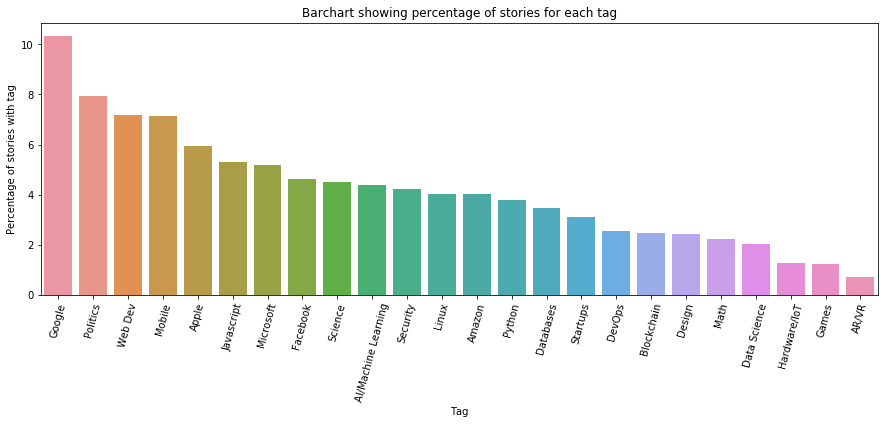

In [12]:
tag_count_df["pct_count"] = tag_count_df["count"] / tag_count_df["count"].sum() * 100

plt.figure(figsize=(15, 5))
sns.barplot(x="index", y="pct_count", data=tag_count_df)
plt.xticks(rotation=75)
plt.title("Barchart showing percentage of stories for each tag")
plt.ylabel("Percentage of stories with tag")
plt.xlabel("Tag")
plt.show()

In [13]:
story_count_df = tagged_df.sum(axis='columns', numeric_only=True).to_frame(name="num_tags").groupby(['num_tags']).size().to_frame(name="count").reset_index()

In [14]:
y_matrix = tagged_df[tags_list].values

In [15]:
has_tags_series_indices = [get_series_index(each_id) for each_id in has_tags_ids]

In [16]:
has_tags_lda_corpus = lda_100_corpus[has_tags_series_indices]

In [17]:
has_tags_lsi_corpus = lsi_300_corpus[has_tags_series_indices]

In [18]:
has_tags_lda_csc = corpus2csc(has_tags_lda_corpus)

In [19]:
has_tags_lsi_csc = corpus2csc(has_tags_lsi_corpus)

In [20]:
lda_X_train, lda_X_test, lda_y_train, lda_y_test = train_test_split(has_tags_lda_csc.T, y_matrix, random_state=42)

In [21]:
lsi_X_train, lsi_X_test, lsi_y_train, lsi_y_test = train_test_split(has_tags_lsi_csc.T, y_matrix, random_state=42)

In [115]:
datasets = [
    ('LDA', [lda_X_train, lda_X_test, lda_y_train, lda_y_test]),
    ('LSI', [lsi_X_train, lsi_X_test, lsi_y_train, lsi_y_test])
]

base_classifiers = [
    ('LogReg', LogisticRegression()),
    ('SVM', LinearSVC()),
    ('KNN', KNeighborsClassifier()),
    ('DecisionTrees', DecisionTreeClassifier(random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42))
]

adapted_classifiers = [
    ('BRkNNa', BRkNNaClassifier()),
    ('MLkNN', MLkNN())
]

# dense_classifiers = [
#     ('NeuroFuzzy', MLARAM()),
#     ('GaussianNB', GaussianNB())
# ]

# Must still add GaussianNB, NeuroFuzzy
#     ('SGD', SGDClassifier(random_state=42)),


In [135]:
clf_results = []

In [136]:
%%time

def get_scores(classifier, each_set):
#     train_hamming_loss = np.mean(cross_val_score(classifier, each_set[0], each_set[2], scoring='hamming_loss', n_jobs=-1, cv=3, verbose=1))
#     train_f1_score = np.mean(cross_val_score(classifier, each_set[0], each_set[2], scoring='f1_samples', n_jobs=-1, cv=3, verbose=1))
    classifier.fit(each_set[0], each_set[2])
    predictions = classifier.predict(each_set[1])
    test_f1_score = f1_score(each_set[3], predictions, average='macro')
    test_hamming_loss = hamming_loss(each_set[3], predictions)
    return test_f1_score, test_hamming_loss
        
for set_name, each_set in datasets:
    for clf_name, base_clf in base_classifiers:
        br_classifier = BinaryRelevance(base_clf)
        br_test_f1_score, br_test_hamming_loss = get_scores(br_classifier, each_set)
        clf_results.append((set_name, clf_name, 'BinaryRelevance', br_test_f1_score, br_test_hamming_loss))
        
        cc_classifier = ClassifierChain(base_clf)
        cc_test_f1_score, cc_test_hamming_loss = get_scores(cc_classifier, each_set)
        clf_results.append((set_name, clf_name, 'ClassifierChain', cc_test_f1_score, cc_test_hamming_loss))
        
        lp_classifier = LabelPowerset(base_clf)
        lp_test_f1_score, lp_test_hamming_loss = get_scores(lp_classifier, each_set)
        clf_results.append((set_name, clf_name, 'LabelPowerset', lp_test_f1_score, lp_test_hamming_loss))                                

/Users/jasminetan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jasminetan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jasminetan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jasminetan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

CPU times: user 23min 22s, sys: 18 s, total: 23min 40s
Wall time: 22min 46s


/Users/jasminetan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [137]:
%%time 

for set_name, each_set in datasets:
    for clf_name, adapted_clf in adapted_classifiers:
        classifier = adapted_clf
        test_f1_score, test_hamming_loss = get_scores(classifier, each_set)
        clf_results.append((set_name, clf_name, 'NA', test_f1_score, test_hamming_loss))

/Users/jasminetan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


CPU times: user 1min 13s, sys: 1.79 s, total: 1min 15s
Wall time: 1min 15s


In [138]:
%%time

dense_has_tags_lda = corpus2dense(has_tags_lda_corpus, num_terms=100)
dense_has_tags_lsi = corpus2dense(has_tags_lsi_corpus, num_terms=300)

dense_lda_X_train, dense_lda_X_test, dense_lda_y_train, dense_lda_y_test = train_test_split(dense_has_tags_lda.T, y_matrix, random_state=42)
dense_lsi_X_train, dense_lsi_X_test, dense_lsi_y_train, dense_lsi_y_test = train_test_split(dense_has_tags_lsi.T, y_matrix, random_state=42)

dense_datasets = [
    ('dense_LDA', [dense_lda_X_train, dense_lda_X_test, dense_lda_y_train, dense_lda_y_test]),
    ('dense_LSI', [dense_lsi_X_train, dense_lsi_X_test, dense_lsi_y_train, dense_lsi_y_test])
]

CPU times: user 7.84 s, sys: 28.4 s, total: 36.2 s
Wall time: 37.7 s


In [139]:
clf_results_df =  pd.DataFrame(clf_results, columns=["dataset", "classifier", "problem_transformation", "test_f1_score", "test_hamming_loss"])

In [140]:
clf_results_df = clf_results_df.sort_values(["test_f1_score", "test_hamming_loss"], ascending=[False, True])

In [141]:
clf_results_df

,dataset,classifier,problem_transformation,test_f1_score,test_hamming_loss
23,LSI,SVM,LabelPowerset,0.748266,0.022799
5,LDA,SVM,LabelPowerset,0.697078,0.025259
34,LSI,AdaBoost,ClassifierChain,0.693756,0.027082
22,LSI,SVM,ClassifierChain,0.691837,0.030377
33,LSI,AdaBoost,BinaryRelevance,0.685616,0.027346
21,LSI,SVM,BinaryRelevance,0.684195,0.024271
24,LSI,KNN,BinaryRelevance,0.684131,0.026313
39,LSI,MLkNN,NA,0.675382,0.026775
20,LSI,LogReg,LabelPowerset,0.672277,0.028049
6,LDA,KNN,BinaryRelevance,0.671313,0.026731


In [144]:
clf_results_df.groupby(by="dataset").mean()

,test_f1_score,test_hamming_loss
dataset,,
LDA,0.540678,0.035997
LSI,0.561764,0.035398


In [145]:
clf_results_df.groupby(by="classifier").mean()

,test_f1_score,test_hamming_loss
classifier,,
AdaBoost,0.459041,0.044610
BRkNNa,0.000000,0.050387
DecisionTrees,0.524401,0.048311
KNN,0.669941,0.029454
LogReg,0.534876,0.031336
MLkNN,0.670896,0.026390
RandomForest,0.585646,0.031223
SVM,0.677272,0.027456


In [146]:
clf_results_df.groupby(by="problem_transformation").mean()

,test_f1_score,test_hamming_loss
problem_transformation,,
BinaryRelevance,0.590678,0.032108
ClassifierChain,0.601402,0.033573
LabelPowerset,0.533509,0.040514
NA,0.335448,0.038388


In [ ]:
# models = {'knn':(KNeighborsClassifier(), {
#                             'n_neighbors': [1, 3, 5, 9, 15, 21],
#                             'weights': ['uniform', 'distance']
#                         }),
#           'svc':(SVC(),{
#                             'C': np.logspace(-3, 4, 10),
#                             'gamma': np.logspace(-5, 4, 10)
#                         }),
#           'lr':(LogisticRegression(), {
#               'penalty': ['l1','l2'],
#               'C': 10.0 ** np.arange(-2, 3)}),
#               'class_weight': [None, "balanced"]
#          }

In [143]:
%%time

parameters = {
    'classifier': [LinearSVC(random_state=42)],
    'classifier__C': np.logspace(-3, 4, 10),
}

top_clf = GridSearchCV(LabelPowerset(), parameters, scoring='f1_macro', cv=3, verbose=2, n_jobs=-1)

top_clf.fit(has_tags_lsi_csc.T, y_matrix)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jasminetan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jasminetan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jasminetan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jasminetan/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

CPU times: user 25.4 s, sys: 311 ms, total: 25.7 s
Wall time: 7min 16s


In [148]:
print("Best params: {}".format(top_clf.best_params_))
print("Best score: {}".format(top_clf.best_score_))

Best params: {'classifier': LinearSVC(C=1.291549665014884, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=42,
     tol=0.0001, verbose=0), 'classifier__C': 1.291549665014884}
Best score: 0.729936533472916


In [151]:
best_clf = LabelPowerset(LinearSVC(C=1.291549665014884, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=42,
     tol=0.0001, verbose=0))

best_clf.fit(lsi_X_train, lsi_y_train)

predictions = best_clf.predict(lsi_X_test)

In [178]:
accuracy_score(lsi_y_test, predictions)

0.680021085925145

In [175]:
def visualize_clf_accuracy(clf_y_test, clf_y_pred):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(clf_y_test, clf_y_pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True,
                          title='Normalized confusion matrix')
    plt.show()

    # Display classification report:
    print("")
    print("Classification Report:")
    print(classification_report(clf_y_test, clf_y_pred))

##### Tag: Python #####
Hamming loss: 0.00790722192936215

Subset accuracy: 0.9920927780706379


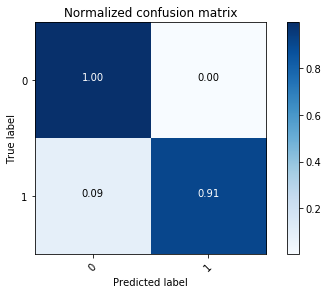


Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1819
          1       0.90      0.91      0.90        78

avg / total       0.99      0.99      0.99      1897


----------

##### Tag: Mobile #####
Hamming loss: 0.06167633104902478

Subset accuracy: 0.9383236689509752


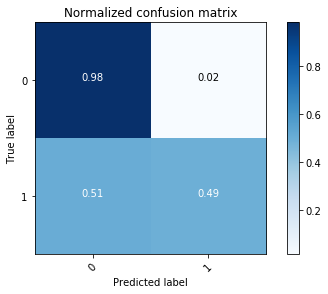


Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.98      0.97      1727
          1       0.73      0.49      0.59       170

avg / total       0.93      0.94      0.93      1897


----------

##### Tag: Design #####
Hamming loss: 0.02635740643120717

Subset accuracy: 0.9736425935687928


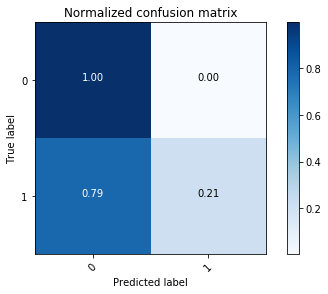


Classification Report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1841
          1       0.67      0.21      0.32        56

avg / total       0.97      0.97      0.97      1897


----------

##### Tag: Security #####
Hamming loss: 0.04059040590405904

Subset accuracy: 0.959409594095941


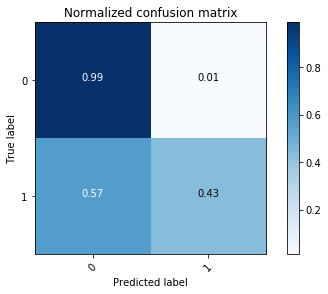


Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      1798
          1       0.67      0.43      0.53        99

avg / total       0.95      0.96      0.96      1897


----------

##### Tag: Blockchain #####
Hamming loss: 0.005798629414865577

Subset accuracy: 0.9942013705851345


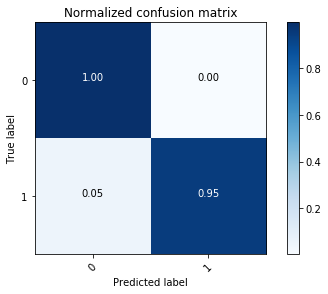


Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1838
          1       0.88      0.95      0.91        59

avg / total       0.99      0.99      0.99      1897


----------

##### Tag: AI/Machine Learning #####
Hamming loss: 0.011597258829731154

Subset accuracy: 0.9884027411702688


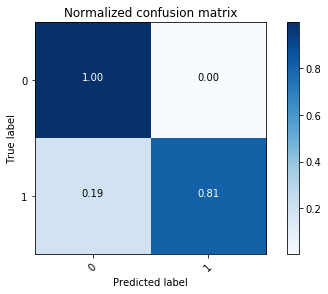


Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1813
          1       0.92      0.81      0.86        84

avg / total       0.99      0.99      0.99      1897


----------

##### Tag: Google #####
Hamming loss: 0.07801792303637323

Subset accuracy: 0.9219820769636268


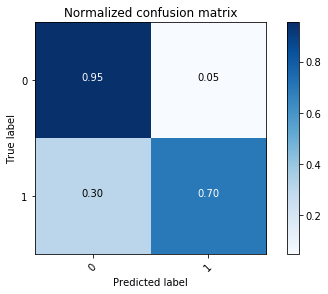


Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.95      0.96      1667
          1       0.67      0.70      0.68       230

avg / total       0.92      0.92      0.92      1897


----------

##### Tag: Microsoft #####
Hamming loss: 0.024248813916710597

Subset accuracy: 0.9757511860832894


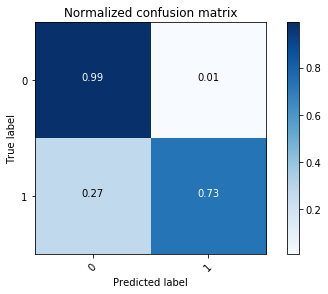


Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      1777
          1       0.86      0.73      0.79       120

avg / total       0.97      0.98      0.97      1897


----------

##### Tag: Apple #####
Hamming loss: 0.0279388508170796

Subset accuracy: 0.9720611491829204


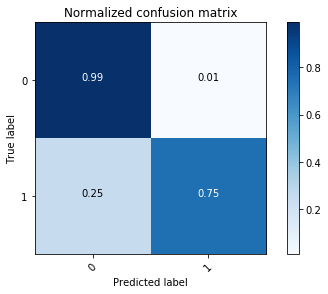


Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      1757
          1       0.85      0.75      0.80       140

avg / total       0.97      0.97      0.97      1897


----------

##### Tag: Facebook #####
Hamming loss: 0.015287295730100159

Subset accuracy: 0.9847127042698999


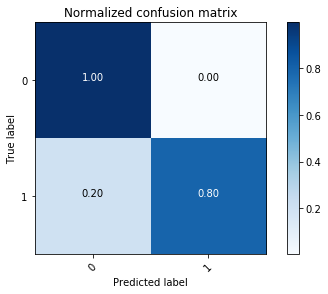


Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1789
          1       0.92      0.80      0.86       108

avg / total       0.98      0.98      0.98      1897


----------

##### Tag: Amazon #####
Hamming loss: 0.010015814443858724

Subset accuracy: 0.9899841855561413


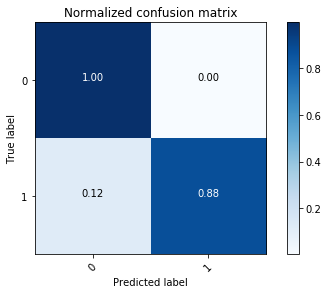


Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1799
          1       0.92      0.88      0.90        98

avg / total       0.99      0.99      0.99      1897


----------

##### Tag: Startups #####
Hamming loss: 0.0158144438587243

Subset accuracy: 0.9841855561412757


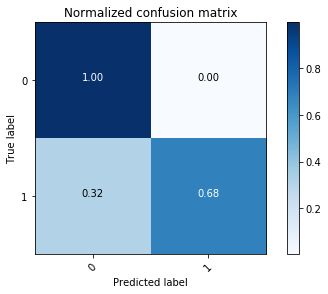


Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1821
          1       0.90      0.68      0.78        76

avg / total       0.98      0.98      0.98      1897


----------

##### Tag: Politics #####
Hamming loss: 0.037954665260938325

Subset accuracy: 0.9620453347390617


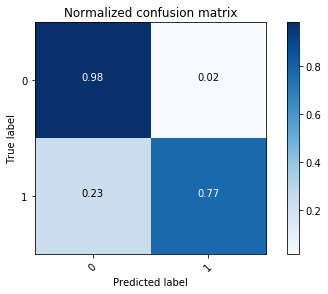


Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.98      0.98      1706
          1       0.84      0.77      0.80       191

avg / total       0.96      0.96      0.96      1897


----------

##### Tag: Databases #####
Hamming loss: 0.010015814443858724

Subset accuracy: 0.9899841855561413


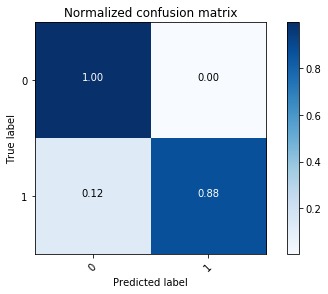


Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1809
          1       0.91      0.88      0.89        88

avg / total       0.99      0.99      0.99      1897


----------

##### Tag: Linux #####
Hamming loss: 0.017923036373220874

Subset accuracy: 0.9820769636267791


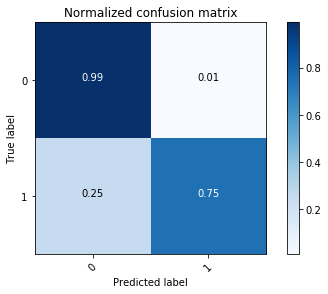


Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      1822
          1       0.79      0.75      0.77        75

avg / total       0.98      0.98      0.98      1897


----------

##### Tag: Data Science #####
Hamming loss: 0.0158144438587243

Subset accuracy: 0.9841855561412757


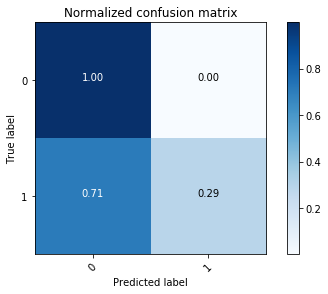


Classification Report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      1856
          1       0.92      0.29      0.44        41

avg / total       0.98      0.98      0.98      1897


----------

##### Tag: Science #####
Hamming loss: 0.030574591460200317

Subset accuracy: 0.9694254085397996


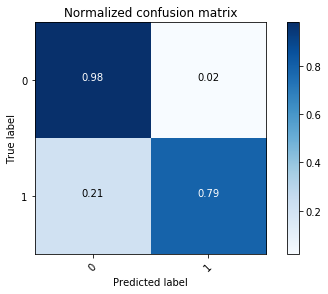


Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.98      0.98      1796
          1       0.68      0.79      0.73       101

avg / total       0.97      0.97      0.97      1897


----------

##### Tag: Math #####
Hamming loss: 0.010542962572482868

Subset accuracy: 0.9894570374275171


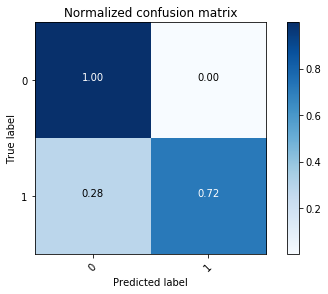


Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1837
          1       0.93      0.72      0.81        60

avg / total       0.99      0.99      0.99      1897


----------

##### Tag: Javascript #####
Hamming loss: 0.0316288877174486

Subset accuracy: 0.9683711122825513


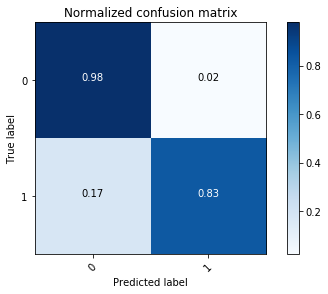


Classification Report:
             precision    recall  f1-score   support

          0       0.99      0.98      0.98      1771
          1       0.73      0.83      0.78       126

avg / total       0.97      0.97      0.97      1897


----------

##### Tag: Web Dev #####
Hamming loss: 0.03742751713231418

Subset accuracy: 0.9625724828676858


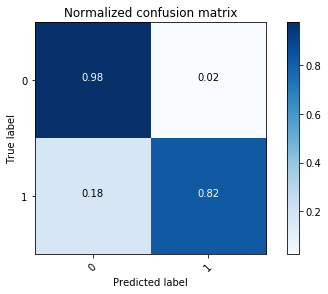


Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      1729
          1       0.77      0.82      0.80       168

avg / total       0.96      0.96      0.96      1897


----------

##### Tag: DevOps #####
Hamming loss: 0.011597258829731154

Subset accuracy: 0.9884027411702688


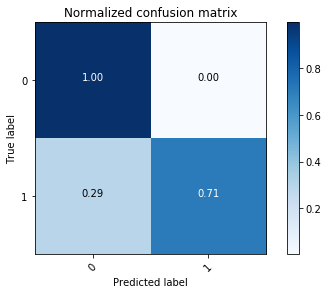


Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1839
          1       0.89      0.71      0.79        58

avg / total       0.99      0.99      0.99      1897


----------

##### Tag: Hardware/IoT #####
Hamming loss: 0.005798629414865577

Subset accuracy: 0.9942013705851345


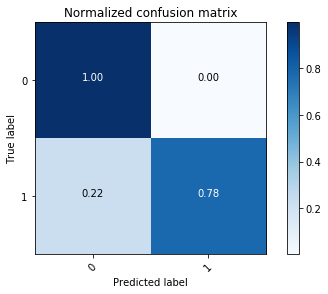


Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1870
          1       0.81      0.78      0.79        27

avg / total       0.99      0.99      0.99      1897


----------

##### Tag: AR/VR #####
Hamming loss: 0.002635740643120717

Subset accuracy: 0.9973642593568793


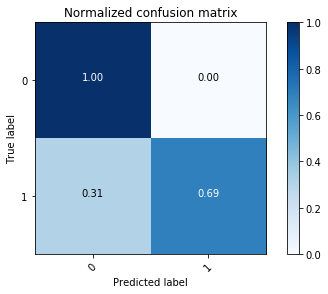


Classification Report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1881
          1       1.00      0.69      0.81        16

avg / total       1.00      1.00      1.00      1897


----------

##### Tag: Games #####
Hamming loss: 0.010542962572482868

Subset accuracy: 0.9894570374275171


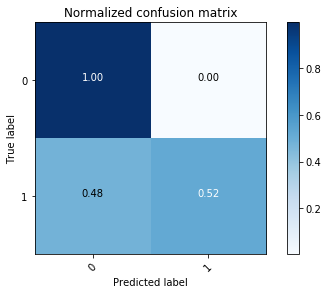


Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1872
          1       0.62      0.52      0.57        25

avg / total       0.99      0.99      0.99      1897


----------



In [176]:
for label in range(predictions.shape[1]):
    print("##### Tag: {} #####".format(tags_list[label]))
    
    y_true = lsi_y_test[:, label]
    y_pred = predictions.todense()[:, label]
    
    print('Hamming loss: {0}'.format(hamming_loss(y_true, y_pred)))
    print("")
    # For comparison sake:
    import sklearn.metrics

    # Subset accuracy
    # 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
    print('Subset accuracy: {0}'.format(accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)))
    
    visualize_clf_accuracy(y_true, y_pred)
                     
    print("")
    print("----------")
    print("")

In [195]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 500)

In [204]:
tagged_df[tagged_df["Mobile"] == 1][["title", "Mobile"]]

,title,Mobile
id,,
15477286,US telcos appear to be selling non-anonymized access to consumer telephone data,1
5632934,Path texts my entire phonebook at 6 AM,1
16025112,A Message to Our Customers about iPhone Batteries and Performance,1
12360662,NSO Group's iPhone Zero-Days used against a UAE Human Rights Defender,1
9271246,React Native is now open source,1
6722292,The second operating system hiding in every mobile phone,1
15230871,iPhone X,1
13629593,A US-born NASA scientist was detained at the border until he unlocked his phone,1
10744206,The first person to hack the iPhone is building a self-driving car,1
